## Comparing DLC Camera CSV 3D coordinate Data to Autobender/Rotary Encoder

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from config import path_to_repository
from analysis import DLC3DBendAngles
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [50]:
#load rotary encoder csv, camera 3d data form DLC csv, and flir_data.mat with timestamps from python camera acquisition

renc = os.path.join(path_to_repository , "CSV Data/8_13_25/2025_08_13_10_55_23/rpi_data/data_rotenc_2025_08_13_10_55_21.csv")
df_renc = pd.read_csv(renc)  
cam = os.path.join(path_to_repository , "CSV Data/8_13_25/2025_08_13_10_55_23/8.13_DLC_3D.csv")
cam_timestamp = os.path.join(
    path_to_repository,
    "CSV Data/8_13_25/2025_08_13_10_55_23/flir_data.mat"
)


In [51]:
#load DLC 3d coordinates from DLC triangulation
cam = DLC3DBendAngles(cam)

# Load only variables starting with 'ts' -> timestamp data
df_ts = cam.load_mat_as_df(cam_timestamp, prefix="ts")

In [52]:
#check number of rows from  cam dataframe (taken from DLC csv) and df_ts dataframe (timestamps form flir_data.mat file).  They hopefully are the same.  If not, need to determine which frames dropped.
rows_renc, rows_cam = DLC3DBendAngles.compare_row_counts(cam.df, df_ts)

DataFrame 1: 140 rows
DataFrame 2: 140 rows


In [53]:
#add camera timestamp columns to 3d dlc data
cam.add_dataframe(df_ts)

scorer     DLC_3D                                                      \
    bodyparts        PIP                            MCP                        
       coords          x         y          z         x         y          z   
0           0        NaN       NaN        NaN -9.219865 -3.754209  18.754984   
1           1  -9.566504 -4.207022  20.501398 -9.220099 -3.752977  18.755037   
2           2  -9.566445 -4.206971  20.501524 -9.221335 -3.752517  18.756477   
3           3  -9.565941 -4.207095  20.504120 -9.224165 -3.751069  18.760826   
4           4  -9.566763 -4.208692  20.515835 -9.224022 -3.751655  18.764820   
..        ...        ...       ...        ...       ...       ...        ...   
135       135  -9.853231 -4.425631  21.587608 -9.362945 -3.955767  19.355250   
136       136  -9.959945 -4.410884  21.945683 -9.357434 -3.958288  19.347563   
137       137 -10.077133 -4.388728  22.340998 -9.352991 -3.959020  19.337019   
138       138 -10.120070 -4.402548  22.491554 -9.351990 -3.962239  19.328453   
139       139 -10.163376 -4.418688  22.634476 -9.354270 -3.963247  19.325825   

                                                                   \
         hand                        forearm                        
            x         y          z         x         y          z   
0   -8.933744 -3.436514  16.991968 -8.779913 -2.950621  14.778589   
1   -8.933089 -3.436171  16.990726 -8.779542 -2.950816  14.778365   
2   -8.933123 -3.435971  16.991167 -8.780002 -2.950198  14.779385   
3   -8.933108 -3.435687  16.991734 -8.780142 -2.950378  14.779813   
4   -8.933717 -3.436865  16.994286 -8.780111 -2.951103  14.780919   
..        ...       ...        ...       ...       ...        ...   
135 -9.016825 -3.617921  17.433120 -8.775392 -3.106112  15.058361   
136 -9.017302 -3.616495  17.429314 -8.778151 -3.104486  15.057918   
137 -9.016860 -3.616534  17.427162 -8.778488 -3.104587  15.057695   
138 -9.019609 -3.614922  17.429296 -8.780540 -3.104127  15.058119   
139 -9.020485 -3.615770  17.428503 -8.785893 -3.102902  15.059812   

      ts_25183199   ts_25185174  
                                 
                                 
0    105527575786  105527581113  
1    105527624637  105527629633  
2    105527675346  105527681457  
3    105527724713  105527728710  
4    105527775422  105527782436  
..            ...           ...  
135  105534356366  105534358361  
136  105534407374  105534409375  
137  105534457699  105534461699  
138  105534507687  105534511691  
139  105534557347  105534559347  

[140 rows x 15 columns]

## Bend Angle obtained from Dot Product Formula

## $\theta = \cos^{-1} \left( \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \, \|\mathbf{v}_2\|} \right)$

As an example:  

V1 is vector from hand to MCP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)

V2 is vector from MCP to PIP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)


In [55]:
#Calculte bend angles from DLC 3d trianglulated data

# --- MCP bend ---
hand_pts = cam.get_points("hand")
mcp_pts  = cam.get_points("MCP")
pip_pts  = cam.get_points("PIP")

v1_mcp = cam.vector(hand_pts, mcp_pts)  # hand→MCP
v2_mcp = cam.vector(mcp_pts, pip_pts)   # MCP→PIP
angles_mcp = cam.angle_from_vectors(v1_mcp, v2_mcp)

# --- Wrist angle ---
forearm_pts = cam.get_points("forearm")
hand_pts = cam.get_points("hand")
mcp_pts = cam.get_points("MCP")

v1_wrist = cam.vector(forearm_pts, hand_pts)  # forearm→hand
v2_wrist = cam.vector(hand_pts, mcp_pts)      # hand→MCP
angles_wrist = cam.angle_from_vectors(v1_wrist, v2_wrist)

# --- Add both angles to a copy of the DataFrame ---
df_out = cam.df.copy()
df_out[("metric", "mcp_bend_deg", "deg")]   = angles_mcp
df_out[("metric", "wrist_bend_deg", "deg")] = angles_wrist

cam.add_dataframe(df_out)



scorer     DLC_3D                                                      \
    bodyparts        PIP                            MCP                        
       coords          x         y          z         x         y          z   
0           0        NaN       NaN        NaN -9.219865 -3.754209  18.754984   
1           1  -9.566504 -4.207022  20.501398 -9.220099 -3.752977  18.755037   
2           2  -9.566445 -4.206971  20.501524 -9.221335 -3.752517  18.756477   
3           3  -9.565941 -4.207095  20.504120 -9.224165 -3.751069  18.760826   
4           4  -9.566763 -4.208692  20.515835 -9.224022 -3.751655  18.764820   
..        ...        ...       ...        ...       ...       ...        ...   
135       135  -9.853231 -4.425631  21.587608 -9.362945 -3.955767  19.355250   
136       136  -9.959945 -4.410884  21.945683 -9.357434 -3.958288  19.347563   
137       137 -10.077133 -4.388728  22.340998 -9.352991 -3.959020  19.337019   
138       138 -10.120070 -4.402548  22.491554 -9.351990 -3.962239  19.328453   
139       139 -10.163376 -4.418688  22.634476 -9.354270 -3.963247  19.325825   

                                                                   \
         hand                        forearm                        
            x         y          z         x         y          z   
0   -8.933744 -3.436514  16.991968 -8.779913 -2.950621  14.778589   
1   -8.933089 -3.436171  16.990726 -8.779542 -2.950816  14.778365   
2   -8.933123 -3.435971  16.991167 -8.780002 -2.950198  14.779385   
3   -8.933108 -3.435687  16.991734 -8.780142 -2.950378  14.779813   
4   -8.933717 -3.436865  16.994286 -8.780111 -2.951103  14.780919   
..        ...       ...        ...       ...       ...        ...   
135 -9.016825 -3.617921  17.433120 -8.775392 -3.106112  15.058361   
136 -9.017302 -3.616495  17.429314 -8.778151 -3.104486  15.057918   
137 -9.016860 -3.616534  17.427162 -8.778488 -3.104587  15.057695   
138 -9.019609 -3.614922  17.429296 -8.780540 -3.104127  15.058119   
139 -9.020485 -3.615770  17.428503 -8.785893 -3.102902  15.059812   

      ts_25183199   ts_25185174       metric                 
                                mcp_bend_deg wrist_bend_deg  
                                         deg            deg  
0    105527575786  105527581113          NaN       5.619358  
1    105527624637  105527629633     4.675658       5.655142  
2    105527675346  105527681457     4.685058       5.704941  
3    105527724713  105527728710     4.739370       5.791380  
4    105527775422  105527782436     4.740531       5.763079  
..            ...           ...          ...            ...  
135  105534356366  105534358361     2.798938       4.890270  
136  105534407374  105534409375     2.974923       4.743458  
137  105534457699  105534461699     4.104764       4.665617  
138  105534507687  105534511691     4.450013       4.504425  
139  105534557347  105534559347     4.541906       4.659788  

[140 rows x 17 columns]

In [56]:
# Count how many NAN's in MCP Bend Angle ->  max should be size of number of timestamps from camera data 

col_name = ("metric", "mcp_bend_deg", "deg")  # tuple key in MultiIndex

# Count NaNs
num_nans = cam.df[col_name].isna().sum()

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"NaNs in MCP bend angle: {num_nans} / {total_rows} rows")
print(f"Percent missing: {100 * num_nans / total_rows:.2f}%")

NaNs in MCP bend angle: 67 / 140 rows
Percent missing: 47.86%


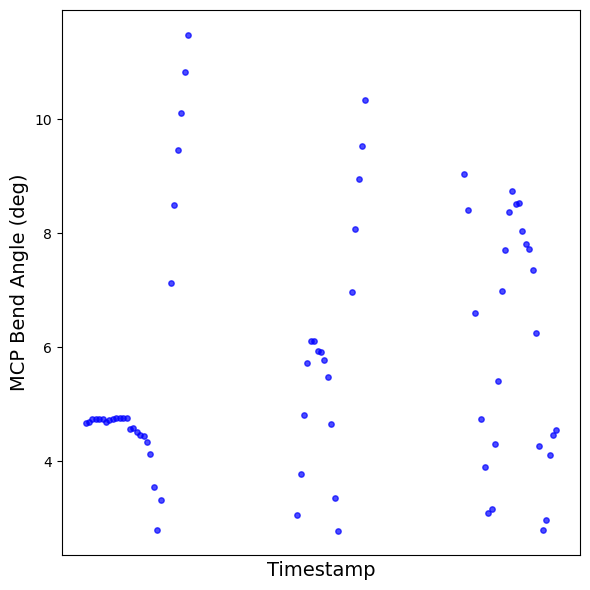

In [57]:
# Plot MCP Bend Angles Calculated from Camera Data vs Camera Timestamp
plt.figure(figsize=(6,6))
plt.scatter(
    cam.df[("ts_25183199", "", "")], 
    cam.df[("metric", "mcp_bend_deg", "deg")],
    s=15, alpha=0.7, color="blue"  # set dots to blue
)

plt.xlabel("Timestamp", fontsize=14)  # bigger label font
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)

# Remove x ticks completely
plt.xticks([])

plt.tight_layout()
plt.savefig("MCP Bend vs timestamp.png", dpi=300, bbox_inches='tight')
plt.show()


In [58]:
cam.df[("ts_25183199", "", "")]

0      105527575786
1      105527624637
2      105527675346
3      105527724713
4      105527775422
           ...     
135    105534356366
136    105534407374
137    105534457699
138    105534507687
139    105534557347
Name: (ts_25183199, , ), Length: 140, dtype: object

In [59]:
df_renc["timestamp"]

0      105521666064
1      105521685585
2      105521705094
3      105521724472
4      105521743748
           ...     
481    105531580681
482    105531601248
483    105531621842
484    105531642421
485    105531663000
Name: timestamp, Length: 486, dtype: int64

## Align Timestamps 

In [61]:
cam.find_matching_indices(
    encoder_df=df_renc,
    cam_time_col=("ts_25183199", "", ""),  # or "ts_25183199"
    enc_time_col="timestamp",

    #--------------- set a timestamp difference threshold here ------------------
    
    tolerance="1000ms",     # <-- was 10000; use an explicit window for clarity

    #--------------- set a timestamp difference threshold here ------------------
    
    direction="nearest",
)

cam.attach_encoder_using_match(
    encoder_df=df_renc,
    columns=None,
    suffix="_renc",
    keep_time_delta=True,
    drop_unmatched=True,
)


[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 10:55:27.575786 → 0 days 10:55:34.557347
[debug] enc range: 0 days 10:55:21.666064 → 0 days 10:55:31.663000


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:248: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:249: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


[debug] probe |delta| (ms) stats: count      20.000000
mean      548.285650
std       859.276066
min         4.053000
25%         5.455500
50%         7.040000
75%       922.222500
max      2593.683000
Name: delta_ms, dtype: float64


,"(scorer, bodyparts, coords)","(DLC_3D, PIP, x)","(DLC_3D, PIP, y)","(DLC_3D, PIP, z)","(DLC_3D, MCP, x)","(DLC_3D, MCP, y)","(DLC_3D, MCP, z)","(DLC_3D, hand, x)","(DLC_3D, hand, y)","(DLC_3D, hand, z)",...,"(DLC_3D, forearm, z)","(ts_25183199, , )","(ts_25185174, , )","(metric, mcp_bend_deg, deg)","(metric, wrist_bend_deg, deg)",timestamp_renc,raw_renc,volts_renc,angle_renc,time_delta_renc
0,0,NaN,NaN,NaN,-9.219865,-3.754209,18.754984,-8.933744,-3.436514,16.991968,...,14.778589,105527575786,105527581113,NaN,5.619358,105527570552,12746,2.389875,18.9890,-5.234
1,1,-9.566504,-4.207022,20.501398,-9.220099,-3.752977,18.755037,-8.933089,-3.436171,16.990726,...,14.778365,105527624637,105527629633,4.675658,5.655142,105527632637,13137,2.463188,13.7105,8.000
2,2,-9.566445,-4.206971,20.501524,-9.221335,-3.752517,18.756477,-8.933123,-3.435971,16.991167,...,14.779385,105527675346,105527681457,4.685058,5.704941,105527673891,13371,2.507062,10.5515,-1.455
3,3,-9.565941,-4.207095,20.504120,-9.224165,-3.751069,18.760826,-8.933108,-3.435687,16.991734,...,14.779813,105527724713,105527728710,4.739370,5.791380,105527715162,13587,2.547563,7.6355,-9.551
4,4,-9.566763,-4.208692,20.515835,-9.224022,-3.751655,18.764820,-8.933717,-3.436865,16.994286,...,14.780919,105527775422,105527782436,4.740531,5.763079,105527777044,13863,2.599312,3.9095,1.622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,NaN,NaN,NaN,-9.245962,-3.808889,18.963240,-8.946593,-3.486361,17.147224,...,14.883526,105532447279,105532449751,NaN,5.430981,105531663000,14076,2.639250,1.0340,-784.279
98,98,NaN,NaN,NaN,-9.246292,-3.808911,18.963352,-8.946426,-3.486515,17.146963,...,14.883389,105532497154,105532499698,NaN,5.452001,105531663000,14076,2.639250,1.0340,-834.154
99,99,NaN,NaN,NaN,-9.247858,-3.808990,18.963907,-8.947478,-3.486703,17.147614,...,14.882412,105532548252,105532550762,NaN,5.427594,105531663000,14076,2.639250,1.0340,-885.252
100,100,NaN,NaN,NaN,-9.250028,-3.813015,18.968185,-8.950846,-3.492595,17.160288,...,14.885930,105532597743,105532599252,NaN,5.294231,105531663000,14076,2.639250,1.0340,-934.743


In [62]:
# Create a smaller dataframe keeping only columns for following:

cols_to_keep = [
    "angle_renc",   
    ("metric", "mcp_bend_deg", "deg"),
    ("metric", "wrist_bend_deg", "deg"),
    "time_delta_renc",  # time difference between camera and rot enc timestamps
]
small_df = cam.df[cols_to_keep].copy()
small_df = small_df.dropna(subset=[("metric", "mcp_bend_deg", "deg")])
small_df = small_df.loc[:, ~small_df.columns.duplicated()].copy()


In [63]:
# Count how many remaining datapoints left  in MCP Bend Angle  after NaN removal from timestamped matched dataframe 

# Count NaNs
remain = len(small_df)

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"Rows after timestamp matching: {total_rows} rows")
print(f"Rows after dropping NaN's in MCP Bend Angle: {remain} rows")

Rows after timestamp matching: 102 rows
Rows after dropping NaN's in MCP Bend Angle: 47 rows


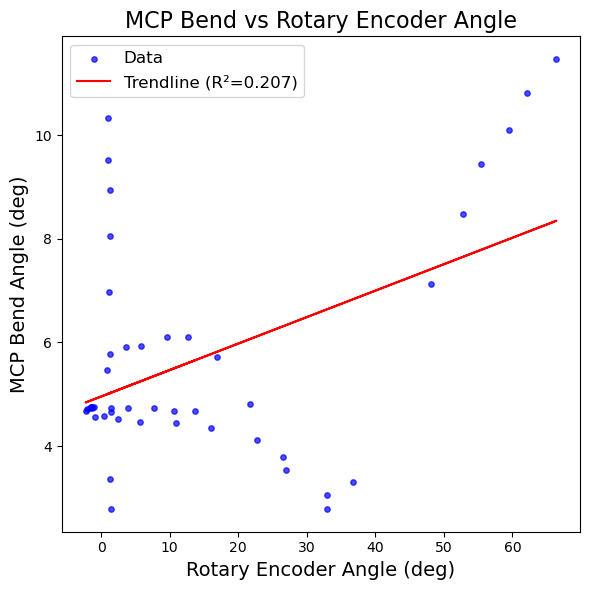

In [64]:
x = small_df["angle_renc"].to_numpy()
y = small_df[("metric", "mcp_bend_deg", "deg")].to_numpy()

# Fit linear regression (y = m*x + b)
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b

# Compute R²
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(x, y, s=15, alpha=0.7, color="blue", label="Data")  # blue dots
plt.plot(x, y_pred, color="red", label=f"Trendline (R²={r2:.3f})")

plt.xlabel("Rotary Encoder Angle (deg)", fontsize=14)  # bigger labels
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)
plt.title("MCP Bend vs Rotary Encoder Angle", fontsize=16)

plt.grid(False)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("MCP Bend vs rot enc.png", dpi=300, bbox_inches='tight')
plt.show()
